# Soft-DTW loss for PyTorch neural network

This notebook is inspired by the notebook of Romain Tavenard about Alignment-based metrics in Machine Learning: 

https://github.com/rtavenar/notebooks-ml4ts/blob/main/03_align4ml_sol.ipynb

The aim here is to use the Soft Dynamic Time Warping metric as a loss function for a PyTorch Neural Network.

# Import the modules

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.insert(0, module_path)
    
# import time

# import numpy as np
# import matplotlib.pyplot as plt
# import torch
# from celluloid import Camera
# from IPython.display import HTML

# from tslearn.backend import instanciate_backend
# from tslearn.metrics import SoftDTW, soft_dtw_alignment, SquaredEuclidean


import numpy as np
import matplotlib.pyplot as plt
import time
from tslearn.datasets import CachedDatasets
from tslearn.metrics import SoftDTWLossPyTorch

# Load the dataset

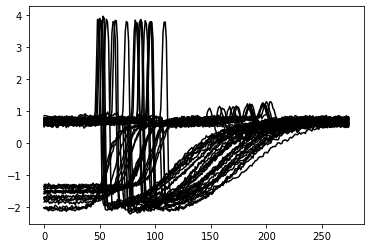

In [2]:
data_loader = CachedDatasets()
X_train, y_train, X_test, y_test = data_loader.load_dataset("Trace")

X_subset = X_train[y_train < 4]
np.random.shuffle(X_subset)
X_subset = X_subset[:50]

for ts in X_subset:
    plt.plot(ts[:, 0], color='k')

# Multi-step ahead forecasting

In [3]:
import torch
from torch import nn

class MultiLayerPerceptron(torch.nn.Module):  # No hidden layer here
    def __init__(self, layers, loss=None):
        # At init, we define our layers
        super(MultiLayerPerceptron, self).__init__()
        self.layers = layers
        if loss is None:
            self.loss = torch.nn.MSELoss(reduction="none")
        else:
            self.loss = loss
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.001)
            

    def forward(self, X):
        # The forward method informs about the forward pass: how one computes outputs of the network
        # from the input and the parameters of the layers registered at init
        if not isinstance(X, torch.Tensor):
            X = torch.Tensor(X)
        batch_size = X.size(0)
        X_reshaped = torch.reshape(X, (batch_size, -1))  # Manipulations to deal with time series format
        output = self.layers(X_reshaped)
        return torch.reshape(output, (batch_size, -1, 1))  # Manipulations to deal with time series format
    
    def fit(self, X, y, max_epochs=10):
        # The fit method performs the actual optimization
        X_torch = torch.Tensor(X)
        y_torch = torch.Tensor(y)

        for e in range(max_epochs):
            self.optimizer.zero_grad()
            # Forward pass
            y_pred = self.forward(X_torch)
            # Compute Loss
            loss = self.loss(y_pred, y_torch).mean()
            if e % 20 == 0:
                print('Epoch {}: train loss: {}'.format(e, loss.item()))
            # Backward pass
            loss.backward()
            self.optimizer.step()

## Multilayer Perceptron model using the class above with PyTorch default loss function

In [4]:
model = MultiLayerPerceptron(
    layers=nn.Sequential(
        nn.Linear(in_features=150, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=125)
    )
)

time_start = time.time()
model.fit(X_subset[:, :150], X_subset[:, 150:], max_epochs=1000)  # Here one needs to define what X and y are, obviously
time_end = time.time()
print('\n Training time: ', time_end - time_start)

Epoch 0: train loss: 0.4909100830554962
Epoch 20: train loss: 0.4809751510620117
Epoch 40: train loss: 0.4713825285434723
Epoch 60: train loss: 0.4620981514453888
Epoch 80: train loss: 0.453110009431839
Epoch 100: train loss: 0.4444064795970917
Epoch 120: train loss: 0.4359634816646576
Epoch 140: train loss: 0.4277697801589966
Epoch 160: train loss: 0.4198037087917328
Epoch 180: train loss: 0.41205406188964844
Epoch 200: train loss: 0.40450727939605713
Epoch 220: train loss: 0.3971574604511261
Epoch 240: train loss: 0.38999420404434204
Epoch 260: train loss: 0.38300976157188416
Epoch 280: train loss: 0.3762025535106659
Epoch 300: train loss: 0.36956357955932617
Epoch 320: train loss: 0.36307549476623535
Epoch 340: train loss: 0.3567350506782532
Epoch 360: train loss: 0.3505413234233856
Epoch 380: train loss: 0.34448546171188354
Epoch 400: train loss: 0.3385639190673828
Epoch 420: train loss: 0.33276909589767456
Epoch 440: train loss: 0.3270948529243469
Epoch 460: train loss: 0.32153719

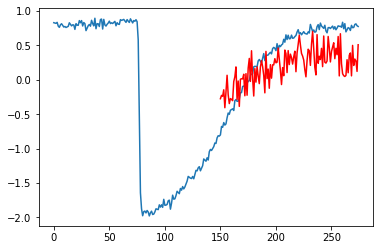

In [5]:
ts_index = 50

y_pred = model(X_test[:, :150, 0]).detach().numpy()

plt.figure()
plt.plot(X_test[ts_index].ravel())
plt.plot(np.arange(150, 275), y_pred[ts_index], 'r-')
plt.show()

## Multilayer perceptron using Soft-DTW metrics as a loss function

In [6]:
model = MultiLayerPerceptron(
    layers=nn.Sequential(
        nn.Linear(in_features=150, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=125)
    ),
    loss=SoftDTWLossPyTorch(gamma=0.1, normalize=False, dist_func=None)
)

time_start = time.time()
model.fit(X_subset[:, :150], X_subset[:, 150:], max_epochs=100)
time_end = time.time()
print('\n Training time: ', time_end - time_start)

Epoch 0: train loss: 23.087909698486328
Epoch 20: train loss: -5.9385857582092285
Epoch 40: train loss: -12.818497657775879
Epoch 60: train loss: -15.704614639282227
Epoch 80: train loss: -17.199851989746094

 Training time:  10.081981420516968


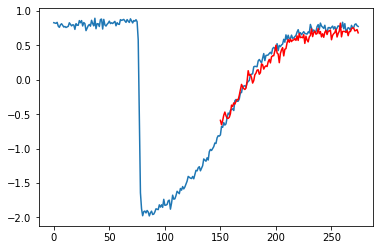

In [7]:
ts_index = 50

y_pred = model(X_test[:, :150, 0]).detach().numpy()

plt.figure()
plt.plot(X_test[ts_index].ravel())
plt.plot(np.arange(150, 275), y_pred[ts_index], 'r-')
plt.show()